In [1]:
# =============================================================================
# %% *IMPORTS*
# =============================================================================

from __future__ import print_function

import os

import numpy as np

try:
    import dill as cpl
except(ImportError):
    import cPickle as cpl

import yaml

from hexrd import config
from hexrd import constants as cnst
from hexrd import matrixutil as mutil
from hexrd import instrument
from hexrd.xrd import fitting
from hexrd.xrd import transforms_CAPI as xfcapi

from scipy.optimize import leastsq, least_squares

# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib nbagg
from matplotlib import pyplot as plt

# Choose a bunch of new matplotlib parameter values
newparams = {'savefig.dpi': 150, 'axes.labelsize': 12, 
             'xtick.labelsize': 6, 'ytick.labelsize': 6}

# Update the global rcParams dictionary with the new parameter choices
plt.rcParams.update(newparams)



/Users/joel/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# =============================================================================
# %% *USER INPUT*
# =============================================================================

# hexrd yaml config file
cfg_filename = 'Au_config.yml'
block_id = 0    # only change this if you know what you are doing!

# select which orientaion to use (in case of more than one...)
grain_id = 1
override_grain_params = False

# load previously saved exclusions
use_saved_exclusions = False
excl_filename = 'exclusion_index_%05d.npy' % grain_id

# refit tolerances
n_pixels_tol = 1.0
ome_tol = 0.25

In [3]:
# =============================================================================
# %% Local function definitions
# =============================================================================

# plane data
def load_plane_data(cpkl, key):
    with file(cpkl, "r") as matf:
        mat_list = cpl.load(matf)
    return dict(zip([i.name for i in mat_list], mat_list))[key].planeData


# instrument
def load_instrument(yml):
    with file(yml, 'r') as f:
        icfg = yaml.load(f)
    instr = instrument.HEDMInstrument(instrument_config=icfg)
    for det_key in instr.detectors:
        if 'saturation_level' in icfg['detectors'][det_key].keys():
            sat_level = icfg['detectors'][det_key]['saturation_level']
            print("INFO: Setting panel '%s' saturation level to %e"
                  % (det_key, sat_level))
            instr.detectors[det_key].saturation_level = sat_level
    return instr


def calibrate_instrument_from_sx(
        instr, grain_params, bmat, xyo_det, hkls_idx,
        param_flags=None, dparam_flags=None, ome_period=None,
        xtol=cnst.sqrt_epsf, ftol=cnst.sqrt_epsf,
        factor=10., sim_only=False, use_robust_lsq=False):
    """
    arguments xyo_det, hkls_idx are DICTs over panels

    !!!
        distortion is still hosed...
        Currently a dict of detector keys with
        distortion[key] = [d_func, d_params, d_flags]
    """
    pnames = [
        '{:>24s}'.format('wavelength'),
        '{:>24s}'.format('chi'),
        '{:>24s}'.format('tvec_s[0]'),
        '{:>24s}'.format('tvec_s[1]'),
        '{:>24s}'.format('tvec_s[2]'),
        '{:>24s}'.format('expmap_c[0]'),
        '{:>24s}'.format('expmap_c[0]'),
        '{:>24s}'.format('expmap_c[0]'),
        '{:>24s}'.format('tvec_c[0]'),
        '{:>24s}'.format('tvec_c[1]'),
        '{:>24s}'.format('tvec_c[2]'),
    ]

    for det_key, panel in instr.detectors.iteritems():
        pnames += [
            '{:>24s}'.format('%s tilt[0]' % det_key),
            '{:>24s}'.format('%s tilt[1]' % det_key),
            '{:>24s}'.format('%s tilt[2]' % det_key),
            '{:>24s}'.format('%s tvec[0]' % det_key),
            '{:>24s}'.format('%s tvec[1]' % det_key),
            '{:>24s}'.format('%s tvec[2]' % det_key),
        ]

    # now add distortion if
    for det_key, panel in instr.detectors.iteritems():
        if panel.distortion is not None:
            for j in range(len(panel.distortion[1])):
                pnames.append(
                    '{:>24s}'.format('%s dparam[%d]' % (det_key, j))
                )

    # reset parameter flags for instrument as specified
    if param_flags is None:
        param_flags = instr.param_flags
    else:
        # will throw an AssertionError if wrong length
        instr.param_flags = param_flags

    det_keys = instr.detectors.keys()

    # re-map omegas if need be
    if ome_period is not None:
        for det_key in det_keys:
            xyo_det[det_key][:, 2] = xfcapi.mapAngle(
                    xyo_det[det_key][:, 2],
                    ome_period
            )
    # grain parameters
    expmap_c = grain_params[:3]
    tvec_c = grain_params[3:6]
    vinv_s = grain_params[6:]

    plist_full = instr.calibration_params(expmap_c, tvec_c)

    dfuncs = {}
    ndparams = {}
    dparam_flags = []
    for det_key, panel in instr.detectors.iteritems():
        if panel.distortion is not None:
            dfuncs[det_key] = panel.distortion[0]
            # ititialize to all False...
            ndparams[det_key] = len(panel.distortion[1])
        else:
            dfuncs[det_key] = None
            ndparams[det_key] = 0
        dparam_flags.append(np.zeros(ndparams[det_key], dtype=bool))
    dparam_flags = np.hstack(dparam_flags)
    refine_flags = np.hstack([param_flags, dparam_flags])
    plist_fit = plist_full[refine_flags]
    fit_args = (plist_full, param_flags,
                dfuncs, dparam_flags, ndparams,
                instr, xyo_det, hkls_idx,
                bmat, vinv_s, ome_period,
                instr.beam_vector, instr.eta_vector)
    if sim_only:
        return sxcal_obj_func(
            plist_fit, plist_full, param_flags,
            dfuncs, dparam_flags, ndparams,
            instr, xyo_det, hkls_idx,
            bmat, vinv_s, ome_period,
            instr.beam_vector, instr.eta_vector,
            sim_only=True)
    else:
        print("Set up to refine:")
        for i in np.where(refine_flags)[0]:
            print("\t%s = %1.7e" % (pnames[i], plist_full[i]))

        # run optimization
        if use_robust_lsq:
            result = least_squares(
                sxcal_obj_func, plist_fit, args=fit_args,
                xtol=xtol, ftol=ftol,
                loss='soft_l1', method='trf'
            )
            x = result.x
            resd = result.fun
            mesg = result.message
            ierr = result.status
        else:
            # do least squares problem
            x, cov_x, infodict, mesg, ierr = leastsq(
                sxcal_obj_func, plist_fit, args=fit_args,
                factor=factor, xtol=xtol, ftol=ftol,
                full_output=1
            )
            resd = infodict['fvec']
        if ierr not in [1, 2, 3, 4]:
            raise RuntimeError("solution not found: ierr = %d" % ierr)
        else:
            print("INFO: optimization fininshed successfully with ierr=%d"
                  % ierr)
            print("INFO: %s" % mesg)

        # ??? output message handling?
        fit_params = plist_full
        fit_params[refine_flags] = x

        # run simulation with optimized results
        sim_final = sxcal_obj_func(
            x, plist_full, param_flags,
            dfuncs, dparam_flags, ndparams,
            instr, xyo_det, hkls_idx,
            bmat, vinv_s, ome_period,
            instr.beam_vector, instr.eta_vector,
            sim_only=True)

        # ??? reset instrument here?
        instr.beam_energy = cnst.keVToAngstrom(fit_params[0])
        instr.chi = fit_params[1]
        instr.tvec = fit_params[2:5]
        ii = 11
        jj = ii + 6*instr.num_panels
        for det_key, panel in instr.detectors.iteritems():
            panel.tilt = fit_params[ii:ii + 3]
            panel.tvec = fit_params[ii + 3:ii + 6]
            ii += 6
            # !!! use jj to do distortion...
            if panel.distortion is not None:
                panel.distortion[1] = fit_params[jj:jj + ndparams[det_key]]
                jj += ndparams[det_key]
            pass

        return fit_params, resd, sim_final


def sxcal_obj_func(plist_fit, plist_full, param_flags,
                   dfuncs, dparam_flags, ndparams,
                   instr, xyo_det, hkls_idx,
                   bmat, vinv_s, ome_period,
                   bvec, evec,
                   sim_only=False, return_value_flag=None):
    """
    """
    # stack flags and force bool repr
    refine_flags = np.array(
        np.hstack([param_flags, dparam_flags]),
        dtype=bool)

    # fill out full parameter list
    # !!! no scaling for now
    plist_full[refine_flags] = plist_fit

    # instrument quantities
    wavelength = plist_full[0]
    chi = plist_full[1]
    tvec_s = plist_full[2:5]

    # calibration crystal quantities
    rmat_c = xfcapi.makeRotMatOfExpMap(plist_full[5:8])
    tvec_c = plist_full[8:11]

    # right now just stuck on the end and assumed
    # to all be the same length... FIX THIS
    dparams_all = plist_full[-len(dparam_flags):]
    xy_unwarped = {}
    meas_omes = {}
    calc_omes = {}
    calc_xy = {}
    ii = 11  # offset to start of panels...
    jj = 0
    npts_tot = 0
    for det_key, panel in instr.detectors.iteritems():
        xy_unwarped[det_key] = xyo_det[det_key][:, :2]
        npts_tot += len(xyo_det[det_key])
        dfunc = dfuncs[det_key]
        len_these_dps = ndparams[det_key]
        if dfunc is not None:    # do unwarping
            dparams = dparams_all[jj:jj + len_these_dps]
            jj += len_these_dps
            xy_unwarped[det_key] = dfunc(xy_unwarped[det_key], dparams)
            pass
        meas_omes[det_key] = xyo_det[det_key][:, 2]

        # get these panel params for convenience
        gparams = plist_full[ii:ii + 6]

        rmat_d = xfcapi.makeDetectorRotMat(gparams[:3])
        tvec_d = gparams[3:].reshape(3, 1)

        # transform G-vectors:
        # 1) convert inv. stretch tensor from MV notation in to 3x3
        # 2) take reciprocal lattice vectors from CRYSTAL to SAMPLE frame
        # 3) apply stretch tensor
        # 4) normalize reciprocal lattice vectors in SAMPLE frame
        # 5) transform unit reciprocal lattice vetors back to CRYSAL frame
        gvec_c = np.dot(bmat, hkls_idx[det_key].T)
        vmat_s = mutil.vecMVToSymm(vinv_s)
        ghat_s = mutil.unitVector(np.dot(vmat_s, np.dot(rmat_c, gvec_c)))
        ghat_c = np.dot(rmat_c.T, ghat_s)

        match_omes, calc_omes_tmp = fitting.matchOmegas(
            xyo_det[det_key], hkls_idx[det_key].T,
            chi, rmat_c, bmat, wavelength,
            vInv=vinv_s,
            beamVec=bvec, etaVec=evec,
            omePeriod=ome_period)

        rmat_s_arr = xfcapi.makeOscillRotMatArray(
            chi, np.ascontiguousarray(calc_omes_tmp)
        )
        calc_xy_tmp = xfcapi.gvecToDetectorXYArray(
                ghat_c.T, rmat_d, rmat_s_arr, rmat_c,
                tvec_d, tvec_s, tvec_c
        )
        if np.any(np.isnan(calc_xy_tmp)):
            print("infeasible parameters: "
                  + "may want to scale back finite difference step size")

        calc_omes[det_key] = calc_omes_tmp
        calc_xy[det_key] = calc_xy_tmp

        ii += 6
        pass

    # return values
    if sim_only:
        retval = {}
        for det_key in calc_xy.keys():
            # ??? calc_xy is always 2-d
            retval[det_key] = np.vstack(
                [calc_xy[det_key].T, calc_omes[det_key]]
            ).T
    else:
        meas_xy_all = []
        calc_xy_all = []
        meas_omes_all = []
        calc_omes_all = []
        for det_key in xy_unwarped.keys():
            meas_xy_all.append(xy_unwarped[det_key])
            calc_xy_all.append(calc_xy[det_key])
            meas_omes_all.append(meas_omes[det_key])
            calc_omes_all.append(calc_omes[det_key])
            pass
        meas_xy_all = np.vstack(meas_xy_all)
        calc_xy_all = np.vstack(calc_xy_all)
        meas_omes_all = np.hstack(meas_omes_all)
        calc_omes_all = np.hstack(calc_omes_all)

        diff_vecs_xy = calc_xy_all - meas_xy_all
        diff_ome = xfcapi.angularDifference(calc_omes_all, meas_omes_all)
        retval = np.hstack(
            [diff_vecs_xy,
             diff_ome.reshape(npts_tot, 1)]
        ).flatten()
        if return_value_flag == 1:
            retval = sum(abs(retval))
        elif return_value_flag == 2:
            denom = npts_tot - len(plist_fit) - 1.
            if denom != 0:
                nu_fac = 1. / denom
            else:
                nu_fac = 1.
            nu_fac = 1 / (npts_tot - len(plist_fit) - 1.)
            retval = nu_fac * sum(retval**2)
    return retval


def parse_reflection_tables(cfg, instr, grain_id, refit_idx=None):
    """
    make spot dictionaries
    """
    hkls = {}
    xyo_det = {}
    idx_0 = {}
    for det_key, panel in instr.detectors.iteritems():
        spots_filename = os.path.join(
            cfg.analysis_dir, os.path.join(
                det_key, 'spots_%05d.out' % grain_id
            )
        )

        # load pull_spots output table
        gtable = np.loadtxt(spots_filename)

        # apply conditions for accepting valid data
        valid_reflections = gtable[:, 0] >= 0  # is indexed
        not_saturated = gtable[:, 6] < panel.saturation_level
        print("INFO: panel '%s', grain %d" % (det_key, grain_id))
        print("INFO: %d of %d reflections are indexed"
              % (sum(valid_reflections), len(gtable))
              )
        print("INFO: %d of %d" % (sum(not_saturated), sum(valid_reflections)) +
              " valid reflections be are below" +
              " saturation threshold of %d" % (panel.saturation_level)
              )

        # valid reflections index
        if refit_idx is None:
            idx = np.logical_and(valid_reflections, not_saturated)
            idx_0[det_key] = idx
        else:
            idx = refit_idx[det_key]
            idx_0[det_key] = idx
            print("INFO: input reflection specify " +
                  "%d of %d total valid reflections" % (sum(idx), len(gtable))
                  )

        hkls[det_key] = gtable[idx, 2:5]
        meas_omes = gtable[idx, 12].reshape(sum(idx), 1)
        xyo_det[det_key] = np.hstack([gtable[idx, -2:], meas_omes])
        pass
    return hkls, xyo_det, idx_0

# *INITIALIZATION*

In [4]:
# =============================================================================
# %% INITIALIZATION
# =============================================================================

# read config
cfg = config.open(cfg_filename)[block_id]

# output for eta-ome maps as pickles
working_dir = cfg.working_dir
analysis_name = cfg.analysis_name
analysis_dir = cfg.analysis_dir
analysis_id = "%s_%s" % (analysis_name, cfg.material.active)

# instrument
parfilename = cfg.instrument.parameters
instr = load_instrument(parfilename)
num_panels = instr.num_panels
det_keys = instr.detectors.keys()

# plane data
plane_data = load_plane_data(cfg.material.definitions, cfg.material.active)
bmat = plane_data.latVecOps['B']

# the maximum pixel dimension in the instrument for plotting
max_pix_size = 0.
for panel in instr.detectors.itervalues():
    max_pix_size = max(max_pix_size,
                       max(panel.pixel_size_col, panel.pixel_size_col)
                       )
    pass

# grab omega period
# !!! data should be consistent
# !!! this is in degrees
ome_period = cfg.find_orientations.omega.period

# load reflection tables from grain fit
hkls, xyo_det, idx_0 = parse_reflection_tables(cfg, instr, grain_id)

# load grain parameters
if override_grain_params:
    grain_parameters = np.loadtxt(
        os.path.join(cfg.analysis_dir, 'grains.out'),
        ndmin=2)[grain_id, 3:15]
else:
    instr_cfg = yaml.load(open(cfg.instrument.parameters, 'r'))
    try:
        cal_crystal_dict = instr_cfg['calibration_crystal']
        if cal_crystal_dict['grain_id'] != grain_id:
            raise RuntimeError("grain_id from instrument config is not %d"
                               % grain_id)
        else:
            grain_parameters = np.hstack(
                [cal_crystal_dict['orientation'],
                 cal_crystal_dict['position'],
                 cal_crystal_dict['inv_stretch']]
            )
    except(KeyError):
        raise RuntimeError("instrument config lacks a calibration crystal")

INFO: Setting panel 'GE3' saturation level to 1.400000e+04
INFO: Setting panel 'GE2' saturation level to 1.400000e+04
INFO: Setting panel 'GE1' saturation level to 1.400000e+04
INFO: Setting panel 'GE4' saturation level to 1.400000e+04
INFO: panel 'GE3', grain 1
INFO: 35 of 35 reflections are indexed
INFO: 31 of 35 valid reflections be are below saturation threshold of 14000
INFO: panel 'GE2', grain 1
INFO: 109 of 113 reflections are indexed
INFO: 99 of 109 valid reflections be are below saturation threshold of 14000
INFO: panel 'GE1', grain 1
INFO: 41 of 41 reflections are indexed
INFO: 40 of 41 valid reflections be are below saturation threshold of 14000
INFO: panel 'GE4', grain 1
INFO: 113 of 113 reflections are indexed
INFO: 102 of 113 valid reflections be are below saturation threshold of 14000


<IPython.core.display.Javascript object>


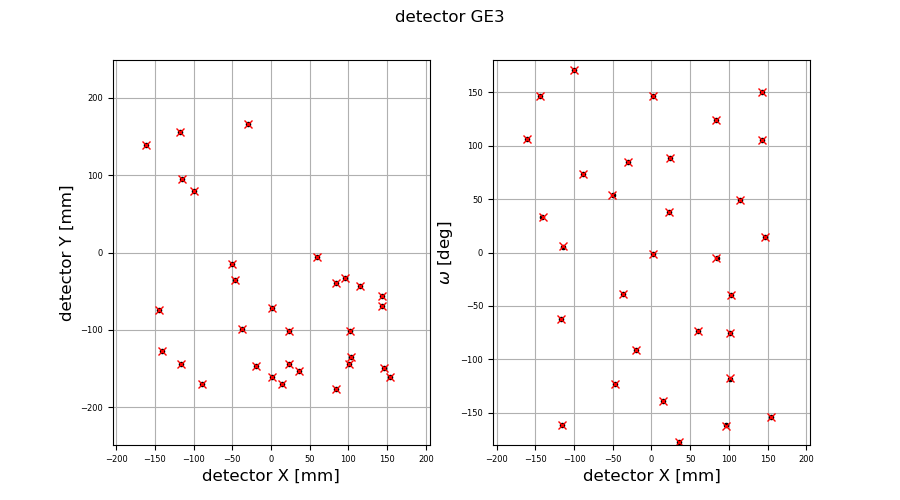

<IPython.core.display.Javascript object>


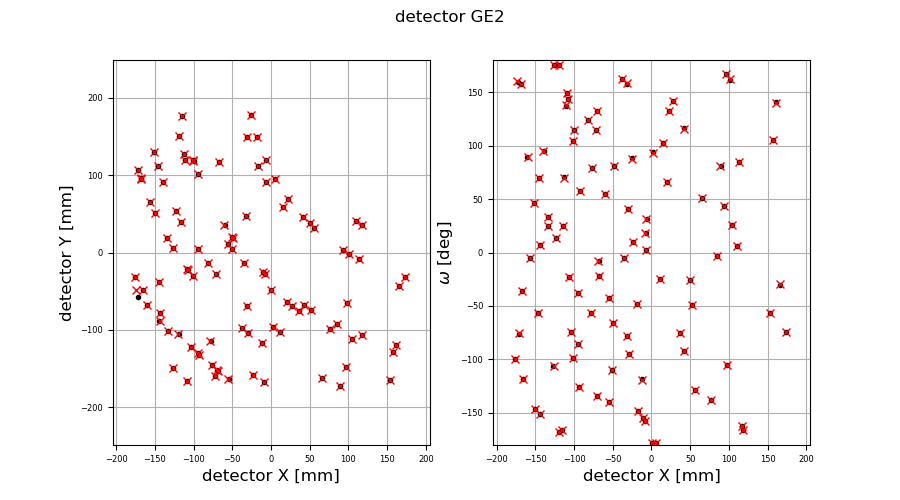

<IPython.core.display.Javascript object>


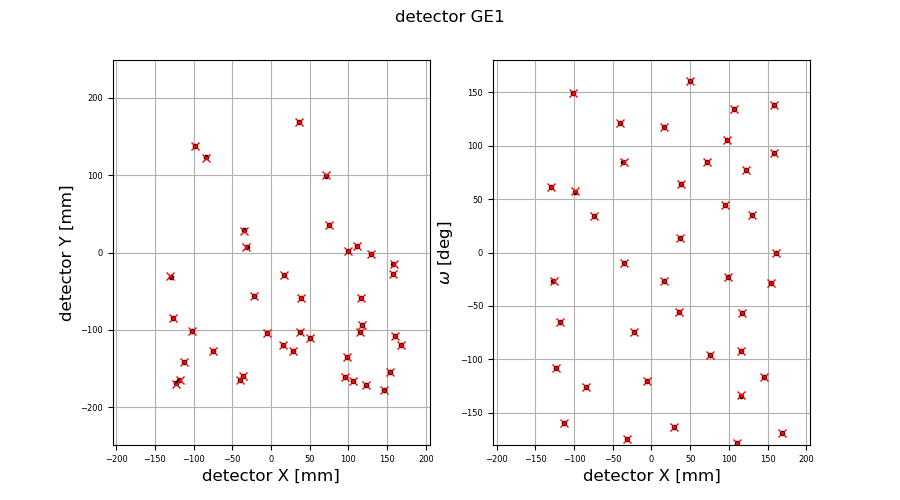

<IPython.core.display.Javascript object>


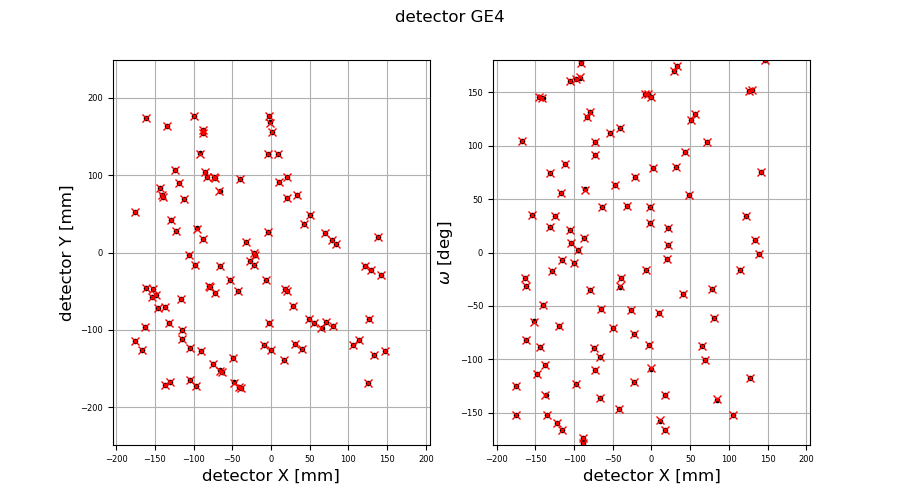

In [5]:
# =============================================================================
# %% plot initial guess
# =============================================================================

xyo_i = calibrate_instrument_from_sx(
    instr, grain_parameters, bmat, xyo_det, hkls,
    ome_period=np.radians(ome_period), sim_only=True
)

for det_key, panel in instr.detectors.iteritems():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(9, 5))
    fig.suptitle("detector %s" % det_key)
    ax[0].plot(xyo_det[det_key][:, 0], xyo_det[det_key][:, 1], 'k.')
    ax[0].plot(xyo_i[det_key][:, 0], xyo_i[det_key][:, 1], 'rx')
    ax[0].grid(True)
    ax[0].axis('equal')
    ax[0].set_xlim(-0.5*panel.col_dim, 0.5*panel.col_dim)
    ax[0].set_ylim(-0.5*panel.row_dim, 0.5*panel.row_dim)
    ax[0].set_xlabel('detector X [mm]')
    ax[0].set_ylabel('detector Y [mm]')

    ax[1].plot(
        xyo_det[det_key][:, 0],
        np.degrees(xyo_det[det_key][:, 2]), 'k.'
    )
    ax[1].plot(xyo_i[det_key][:, 0], np.degrees(xyo_i[det_key][:, 2]), 'rx')
    ax[1].grid(True)
    ax[1].set_xlim(-0.5*panel.col_dim, 0.5*panel.col_dim)
    ax[1].set_ylim(ome_period[0], ome_period[1])
    ax[1].set_xlabel('detector X [mm]')
    ax[1].set_ylabel(r'$\omega$ [deg]')

    fig.show()

# *SKIP TO HERE AND RUN ALL ABOVE*
### If things look pretty good, then we are ready to do the optimization

In [6]:
# =============================================================================
# %% RUN OPTIMIZATION
# =============================================================================

params, resd, xyo_f = calibrate_instrument_from_sx(
    instr, grain_parameters, bmat, xyo_det, hkls,
    ome_period=np.radians(ome_period)
)

Set up to refine:
	                     chi = 6.2569684e-04
	             expmap_c[0] = 6.0984735e-01
	             expmap_c[0] = 4.1287781e-01
	             expmap_c[0] = -2.6350848e-01
	               tvec_c[0] = 0.0000000e+00
	               tvec_c[2] = 0.0000000e+00
	             GE3 tilt[0] = -1.1761886e-03
	             GE3 tilt[1] = -1.8847452e-04
	             GE3 tilt[2] = -2.0533818e+00
	             GE3 tvec[0] = -6.3896519e+01
	             GE3 tvec[1] = 3.0435311e+02
	             GE3 tvec[2] = -1.9202065e+03
	             GE2 tilt[0] = -4.8420968e-04
	             GE2 tilt[1] = 3.1137020e-03
	             GE2 tilt[2] = -4.7468990e-01
	             GE2 tvec[0] = -3.2016338e+02
	             GE2 tvec[1] = -9.5972365e+01
	             GE2 tvec[2] = -1.9202112e+03
	             GE1 tilt[0] = 2.5873183e-03
	             GE1 tilt[1] = 1.8164124e-03
	             GE1 tilt[2] = 1.0934670e+00
	             GE1 tvec[0] = 9.4518006e+01
	             GE1 tvec[1] = -3.3747158e+02
	   

In [7]:
# =============================================================================
# %% Trim relection tables for refit
# =============================================================================

# define difference vectors for spot fits
for det_key, panel in instr.detectors.iteritems():
    x_diff = abs(xyo_det[det_key][:, 0] - xyo_f[det_key][:, 0])
    y_diff = abs(xyo_det[det_key][:, 1] - xyo_f[det_key][:, 1])
    ome_diff = np.degrees(
        xfcapi.angularDifference(
            xyo_det[det_key][:, 2],
            xyo_f[det_key][:, 2])
    )

    # filter out reflections with centroids more than
    # a pixel and delta omega away from predicted value
    idx_1 = np.logical_and(
        x_diff <= n_pixels_tol*panel.pixel_size_col,
        np.logical_and(
            y_diff <= n_pixels_tol*panel.pixel_size_row,
            ome_diff <= ome_tol
        )
    )

    print("INFO: Will keep %d of %d input reflections on panel %s for re-fit"
          % (sum(idx_1), sum(idx_0[det_key]), det_key)
          )

    idx_new = np.zeros_like(idx_0[det_key], dtype=bool)
    idx_new[np.where(idx_0[det_key])[0][idx_1]] = True
    idx_0[det_key] = idx_new

INFO: Will keep 29 of 31 input reflections on panel GE3 for re-fit
INFO: Will keep 77 of 99 input reflections on panel GE2 for re-fit
INFO: Will keep 39 of 40 input reflections on panel GE1 for re-fit
INFO: Will keep 102 of 102 input reflections on panel GE4 for re-fit


In [8]:
# =============================================================================
# %% Look ok? Then proceed with refit
# =============================================================================

# update calibration crystal params
grain_parameters[:3] = params[5:8]
grain_parameters[3:6] = params[8:11]

# reparse data
hkls_refit, xyo_det_refit, idx_0 = parse_reflection_tables(
    cfg, instr, grain_id, refit_idx=idx_0
)

# perform refit
params2, resd2, xyo_f2 = calibrate_instrument_from_sx(
    instr, grain_parameters, bmat, xyo_det_refit, hkls_refit,
    ome_period=np.radians(ome_period)
)

INFO: panel 'GE3', grain 1
INFO: 35 of 35 reflections are indexed
INFO: 31 of 35 valid reflections be are below saturation threshold of 14000
INFO: input reflection specify 29 of 35 total valid reflections
INFO: panel 'GE2', grain 1
INFO: 109 of 113 reflections are indexed
INFO: 99 of 109 valid reflections be are below saturation threshold of 14000
INFO: input reflection specify 77 of 113 total valid reflections
INFO: panel 'GE1', grain 1
INFO: 41 of 41 reflections are indexed
INFO: 40 of 41 valid reflections be are below saturation threshold of 14000
INFO: input reflection specify 39 of 41 total valid reflections
INFO: panel 'GE4', grain 1
INFO: 113 of 113 reflections are indexed
INFO: 102 of 113 valid reflections be are below saturation threshold of 14000
INFO: input reflection specify 102 of 113 total valid reflections
Set up to refine:
	                     chi = 4.3536203e-04
	             expmap_c[0] = 6.0977630e-01
	             expmap_c[0] = 4.1293981e-01
	             expmap_c

<IPython.core.display.Javascript object>


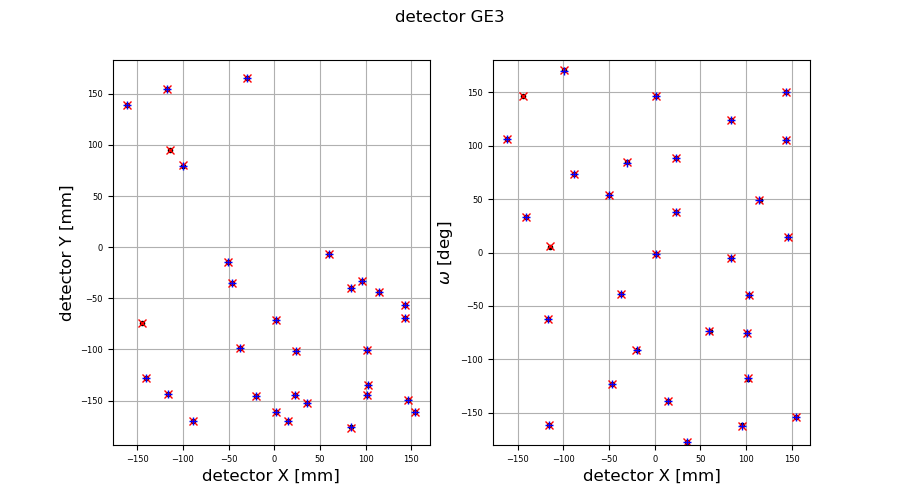

<IPython.core.display.Javascript object>


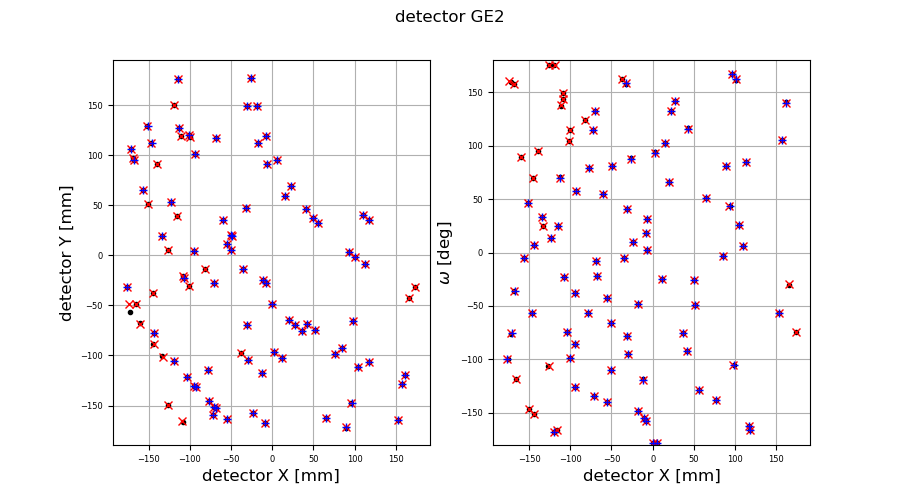

<IPython.core.display.Javascript object>


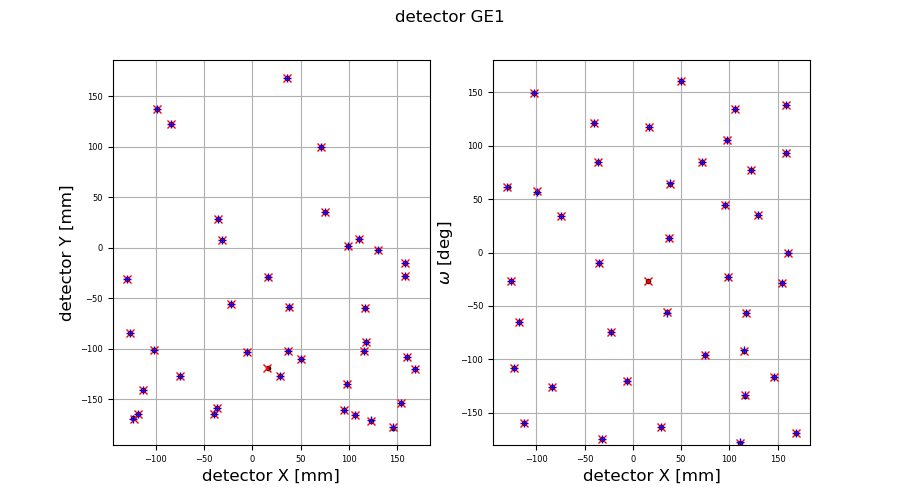

<IPython.core.display.Javascript object>


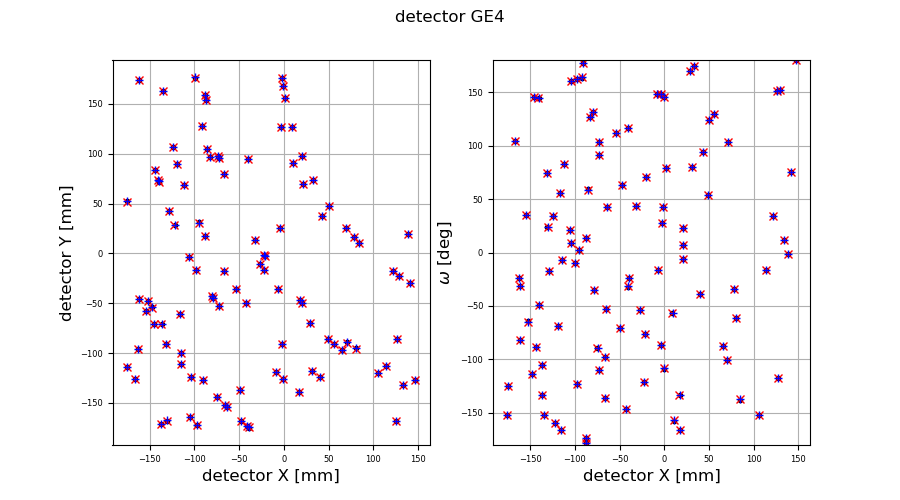

In [9]:
# =============================================================================
# %% plot results
# =============================================================================

for det_key, panel in instr.detectors.iteritems():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(9, 5))
    fig.suptitle("detector %s" % det_key)
    ax[0].plot(xyo_det[det_key][:, 0], xyo_det[det_key][:, 1], 'k.')
    ax[0].plot(xyo_i[det_key][:, 0], xyo_i[det_key][:, 1], 'rx')
    ax[0].plot(xyo_f2[det_key][:, 0], xyo_f2[det_key][:, 1], 'b+')
    ax[0].grid(True)
    ax[0].axis('equal')
    ax[0].set_xlim(-0.5*panel.col_dim, 0.5*panel.col_dim)
    ax[0].set_ylim(-0.5*panel.row_dim, 0.5*panel.row_dim)
    ax[0].set_xlabel('detector X [mm]')
    ax[0].set_ylabel('detector Y [mm]')

    ax[1].plot(
        xyo_det[det_key][:, 0],
        np.degrees(xyo_det[det_key][:, 2]), 'k.'
    )
    ax[1].plot(xyo_i[det_key][:, 0], np.degrees(xyo_i[det_key][:, 2]), 'rx')
    ax[1].plot(xyo_f2[det_key][:, 0], np.degrees(xyo_f2[det_key][:, 2]), 'b+')
    ax[1].grid(True)
    ax[1].set_xlim(-0.5*panel.col_dim, 0.5*panel.col_dim)
    ax[1].set_ylim(ome_period[0], ome_period[1])
    ax[1].set_xlabel('detector X [mm]')
    ax[1].set_ylabel(r'$\omega$ [deg]')

    ax[0].axis('tight')

    fig.show()

In [10]:
# =============================================================================
# %% output results
# =============================================================================

# update calibration crystal params
grain_parameters[:3] = params2[5:8]
grain_parameters[3:6] = params2[8:11]

# update cal dict
cal_crystal_dict['grain_id'] = grain_id
cal_crystal_dict['inv_stretch'] = grain_parameters[6:].tolist()
cal_crystal_dict['orientation'] = grain_parameters[:3].tolist()
cal_crystal_dict['position'] = grain_parameters[3:6].tolist()

# write out
instr.write_config(filename='new_instrument.yml',
                   calibration_dict=cal_crystal_dict)

{'beam': {'energy': 71.67600000000002,
  'vector': {'azimuth': 90.0, 'polar_angle': 90.0}},
 'calibration_crystal': {'grain_id': 1,
  'inv_stretch': [1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
  'orientation': [0.6098251488352522,
   0.41289103567053004,
   -0.26357162738267603],
  'position': [0.026802449693086917, 0.0, 0.007605988661859759]},
 'detectors': {'GE1': {'distortion': {'function_name': 'GE_41RT',
    'parameters': array([ 7.61742412e-05, -1.01006559e-06, -1.64611391e-04,  2.00000000e+00,
            2.00000000e+00,  2.00000000e+00])},
   'pixels': {'columns': 2048, 'rows': 2048, 'size': [0.2, 0.2]},
   'saturation_level': 14000.0,
   'transform': {'t_vec_d': [94.53126752782899,
     -337.4281647085056,
     -1920.9361619948877],
    'tilt_angles': [0.00275979661409406,
     0.0005958772708761478,
     1.093760534972477]}},
  'GE2': {'distortion': {'function_name': 'GE_41RT',
    'parameters': array([ 5.24511118e-05, -3.16535090e-05, -2.07741392e-04,  2.00000000e+00,
            2.0000